## Classification of Activity Recognition from a Single Chest-Mounted Accelerometer
___

Build a supervised learning classification model for data downloaded from a [UCI hosted dataset](http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#). 

"The dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns."
___

<b>Step 1:</b> Import some useful libraries.

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# from pandas import Series, DataFrame
import sklearn
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

<b>Step 2:</b> Load single data file for exploratory analysis.

In [2]:
# Data is all numeric, compatible with loading loaded as a numpy array
csv1 = np.loadtxt('1.csv',delimiter=',')

<b>Step 3:</b> Crop data if necessary.

From visual inspection of several of the 15 individual data files, it appears as if the last line is used for terminating data collection or some other purpose. The activity is coded 0 which does not belong to the 7 class labels described in the readme. While its possible to search the file for all zeros then delete those rows, the fastest approach is just to remove the final row from the dataset. 

In addition the first column appears to just echo the index and isn't necessary for the analysis to be done here so this column can also be removed.

In [3]:
# Remove 0 class from the last line of file, 1st column is index which can also be removed
csv1crop = np.array(csv1[:-1,1:])
print('Data size:', csv1crop.shape, 
      '  Cropped [rows cols]:', np.subtract(csv1.shape,csv1crop.shape))

Data size: (162500, 4)   Cropped [rows cols]: [1 1]


Now the first 3 columns contain the x,y,z acceleromter data and the final column the corresponding activity class. 

Next, a quick check to make sure the remaining data only contains the 7 expected activity classes. Also a quick glance at the data to see how numpy stored it.

In [4]:
# Check all possible classes
set(csv1crop[:,-1])

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}

In [5]:
# Check data type of dataset
csv1crop.dtype

dtype('float64')

<b>Step 4:</b> Visualize raw data. 

It will be useful to see the distribution of datapoints to check for unbalanced classes. This can be identified with a histogram plot.

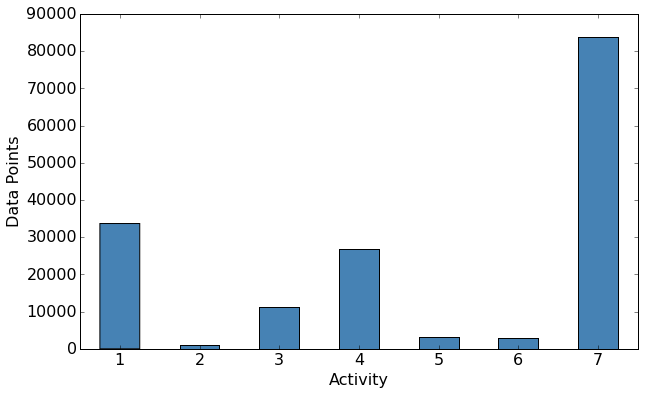

In [6]:
# Check for unequal data set, plot number of data points for each activity
plt.rc('font', family='sans-serif', size='16')
plt.figure(figsize=(10,6))
plt.hist(csv1crop[:,-1], bins=7, range=(1,8), color='SteelBlue', align='left', rwidth=0.5, 
         label=list('1234567'))
plt.xlim(0.5,7.5)
plt.xlabel('Activity')
plt.ylabel('Data Points')

# plt.grid(b=True, which='major', color='#999999', linestyle='-')

In [7]:
# df1 = DataFrame(csv1crop,columns=['X','Y','Z','Activity'])
# df1.head()

<b>Step 5:</b> Create new features if necessary.

Intuitively, 3 features for over <i>160000</i> examples doesn't seem like enough. So it may be useful to create new features. Again from intuition, if using accelerometer data to identify activities, it might be useful to include a feature describing how the spontaneous motion is divided into each direction. One way to do this would be to include pairs of ratios of the x,y,z accelerometer measurements.

In [8]:
# Create new variables consisting of ratios of acceleration in each direction

import itertools
from scipy.misc import factorial

xx = csv1crop[:,:3]

nFeatures = 3
Pairs = list(itertools.combinations(list(range(nFeatures)),2))
Ratios = np.zeros((xx.shape[0],sum(range(nFeatures))))
for i in range(len(Pairs)):
    Ratios[:,i]=np.divide(xx[:,Pairs[i][0]],xx[:,Pairs[i][1]])
xxSup = np.hstack((xx,Ratios))

xxSup.shape

(162500, 6)

<b>Step 6:</b> Standardize data.

The values for the new features are much different in magnitude than the initial features. To ensure one group of features does not dominate the other during learning it is necessary to standardized the features by subtracting the mean value and dividing each feature by the variance.

In [9]:
# Standardize data set to have mean zero and unit variance
from sklearn import preprocessing
Scaling = preprocessing.StandardScaler()

xxScaled = Scaling.fit_transform(xxSup)

np.mean(xxScaled,axis=0), np.std(xxScaled,axis=0)

(array([  1.14693800e-14,   1.11360519e-14,   2.24852888e-15,
          8.82698615e-12,   4.31193753e-12,   2.66665580e-12]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.]))

<b>Step 7:</b> Additional visualization.

Now it might be useful to take another peak at the data using PCA to see if there is a transformation that can be applied to the present features that might best highlight the differences between examples.

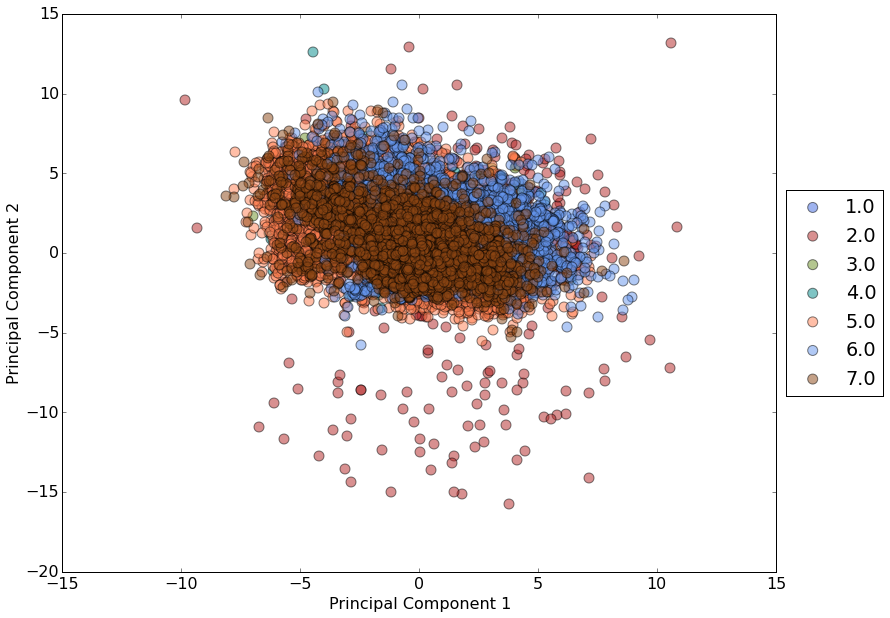

In [10]:
# 2D PCA
from sklearn.decomposition import PCA


yy = csv1crop[:,-1]
LblList= set(yy)

pca = PCA(n_components=2)
pca.fit(xxScaled)
PCACoeff = pca.transform(xxScaled)

# Customize plot font and marker color
plt.rc('font', family='sans-serif', size='16')
ColorOpts = ['RoyalBlue', 'FireBrick', 'OliveDrab', 'DarkCyan', 'Coral', 
             'CornflowerBlue', 'SaddleBrown', 'YellowGreen', 'DarkViolet', 'DarkTurquoise']

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for i,c,class_name in zip(range(len(LblList)),ColorOpts,LblList):
    PointIdx = np.where(np.array(yy)==i)
    ax.scatter(PCACoeff[PointIdx,0], PCACoeff[PointIdx,1], c=c, label=class_name, s=100, linewidth=1, alpha=0.5) 

# Shrink axes box width by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put legend inside or to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)

plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
# PCAmax = np.amax(np.absolute(PCACoeff[:,:2]))
# limLog = np.floor(np.log10(PCAmax))
# limInt = np.ceil(PCAmax/(10**np.floor(np.log10(PCAmax))))
# lim = limInt*(10**limLog)
# plt.xlim(-1*lim,lim)
# plt.ylim(-1*lim,lim)

# plt.subplots_adjust(bottom=0.10,left=0.10,right=0.75,top=0.95,wspace=0.1,hspace=0.1)

From visual inspection there is a significant amount of overlap in the first two PCs here. Not a whole lot to learn from this except that it will be necessary to use some more advanced techniques to try to identify differences and use those differences to classify examples.

## Begin machine learning

<b>Step 8:</b> Begin machine learning process by importing necessary packages.

In [11]:
# Multiclass machine learning algorithm, import packages

import warnings
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split,StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.grid_search import GridSearchCV
from sklearn import tree, ensemble
from sklearn.linear_model import LogisticRegressionCV

Before beginning learning process, select a few rows at random to test a learning algorithm.

In [18]:
# Random shuffle data and take first nCrop rows

nCrop = 2000

ShuffleData = np.copy(xxScaled)
ShuffleData = np.hstack((ShuffleData,np.reshape(yy,(yy.shape[0],1))))
np.random.shuffle(ShuffleData)
X, Y = ShuffleData[:nCrop,:-1], np.array(ShuffleData[:nCrop,-1],dtype=int)

X.shape, Y.shape, X[:5,:], Y[:5]

((2000, 6),
 (2000,),
 array([[ 1.65618489, -0.03068107,  1.39066555,  1.20555431, -0.22522701,
         -1.18175934],
        [-0.72985126,  0.04087404, -0.86032545, -0.56493715,  0.37247704,
          0.75036088],
        [ 0.05729469,  3.64248148, -1.11230206, -2.02482841,  1.37325298,
          2.89893658],
        [-0.6068597 ,  0.01702234, -0.77633325, -0.46186724,  0.37835282,
          0.662425  ],
        [-1.0496293 , -0.00682937, -0.67554261, -0.76833733, -0.1280036 ,
          0.55999236]]),
 array([1, 3, 4, 7, 7]))


Accuracy: 71.35%

Classification Report:

             precision    recall  f1-score   support

          1       0.84      0.96      0.90       807
          2       0.02      0.33      0.04        24
          3       0.08      0.07      0.07       282
          4       0.82      0.56      0.67       670
          5       0.25      0.03      0.05        68
          6       0.20      0.04      0.06        78
          7       0.83      0.81      0.82      2071

avg / total       0.75      0.71      0.72      4000



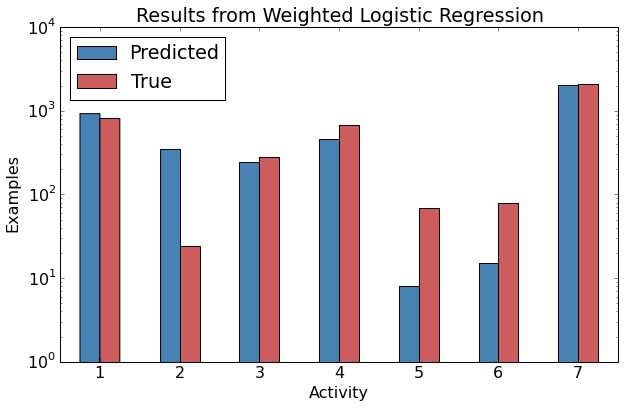

In [32]:
"""
Logistic regression with cross validation to determine best C parameters as well as
class weights to handle the unbalanced classes
"""

# Random shuffle data and take first nCrop rows
nCrop = 10000

ShuffleData = np.copy(xxScaled)
ShuffleData = np.hstack((ShuffleData,np.reshape(yy,(yy.shape[0],1))))
np.random.shuffle(ShuffleData)
X, Y = ShuffleData[:nCrop,:-1], np.array(ShuffleData[:nCrop,-1],dtype=int)


# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state=None)


# Train and test classifier
clflog = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l2', scoring='f1_weighted', 
                              dual=False, class_weight='auto', n_jobs=2)
clflog.fit(X_train, Y_train)
Y_log = clflog.predict(X_test)
 
    
# Output results
print()
print('Accuracy: {:.2%}'.format(accuracy_score(Y_test, Y_log)))
print()
print('Classification Report:')
print()
print(classification_report(Y_test, Y_log, target_names=list('1234567')))


plt.rc('font', family='sans-serif', size='16')
plt.figure(figsize=(10,6))
plt.hist([Y_log, Y_test], bins=7, range=(1,8), color=['SteelBlue','IndianRed'], align='left', 
         histtype='bar', rwidth=0.5, label=['Predicted','True'], log=True)
plt.xlim(0.5,7.5)
plt.xlabel('Activity')
plt.ylabel('Examples')
plt.title('Results from Weighted Logistic Regression')
plt.legend(loc='upper left')
